# Problem 3: NYC Bicycling Trends
On average, are more bikes likely to cross the Brooklyn Bridge in May or September?  Answering that question is the the goal of this problem.   New York City shares a lot of their data on the [OpenData](https://opendata.cityofnewyork.us/) website.  Here, we will analyze data from 2017 that counts the number of bikers crossing NYC bridges each day from April through October.  

The data collected by NYC counts the number of bikers crossing bridges each day.  To model this in our likelihood function, we will employ the Poisson distribution, which is commonly used to describes counts per day or counts per area.  The Poisson distribution describes the probability mass function for a discrete random variable that has a sample space which includes all positive integers.   Let $B$ be a Poisson random variable representing the number of bicycles crossing the Brooklyn Bridge.   The Poisson mass function $m(k)$ takes the form

$$
m(b|\lambda) = \mathbb{P}[B=b] = \frac{\lambda^b e^{-\lambda}}{b!}
$$

The Poisson distribution has a single parameter $\lambda$ that represents the average rate (e.g., bicyclists per day) of the random variable $B$.  Interestingly, both the mean and variance of $B$ are equal to $\lambda$.  Our goal here is to define a posterior density $f(\lambda | b_{May})$ using observations of the bicyclist count in May,  i.e., $b_{May}$, and another posterior density $f(\lambda | b_{Sep})$ using observations of the bicyclist count in September.  Comparing the two posteriors will allow us to compute the probability that more bikers will cross Brooklyn Bridge in May than September.

We will assume that the prior density $f(\lambda)$ is a Gamma density.  The Gamma distribution is a flexible family of distributions useful for describing positive real-valued variables (like $\lambda$).  The probability density function of a Gamma random variable is given by

$$
f(\lambda) = \text{Gamma}(\lambda; k, \theta) = \frac{1}{\Gamma(k)\theta^k} \lambda^{k-1} e^{-\frac{\lambda}{\theta}},
$$

where $k$ and $\theta$ are parameters describing the shape of the density.  


### Part 3:
Read through the code below to and use the result of part 2 to update the `PosteriorParameters` function.  This is labeled as `TODO` in the code.

### Part 4:
Using your code from Part 3, run the code below that computes the posterior parameters $k^\ast_{May},\theta^\ast_{May}$ and $k^\ast_{Sep},\theta^\ast_{Sep}$ using data from May and September, respectively.  Plots of the posterior densities will also be generated. 

Once you've found the posterior parameters, compute the probability that a random variable $\lambda_{May}$ with density $\text{Gamma}(\lambda; k^\ast_{May}, \theta^\ast_{May})$ is greater than a random variable $\lambda_{Sep}$ with density $\text{Gamma}(\lambda; k^\ast_{Sep}, \theta^\ast_{Sep})$.  

*Hint:*  For two independent Gamma random variables $X$ and $Y$ with the same scaling parameter $\theta$ but different parameters $k_x$ and $k_y$, the random variable $Z=X/(X+Y)$ is distributed according to a [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) with parameters $k_x$ and $k_y$.  More precisely,

$$
\frac{X}{X+Y} = Z \sim \text{Beta}(k_x,k_y)
$$


In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt

import numpy as np

import pandas as pd
import datetime

from scipy.stats import poisson, gamma, beta

pd.plotting.register_matplotlib_converters()

In [2]:
def ReadData():
    """ This function reads in bicycle data that has been downloaded from NYC OpenData website at 
        https://data.cityofnewyork.us/Transportation/Bicycle-Counts-for-East-River-Bridges/gua4-p9wg
        
        The data contains weather variables and the total number of bicyclists crossing various 
        bridges around New York City.  This function concatenates data for each summer month in 2017
        and returns a Pandas DataFrame (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html)
        
        RETURNS:
            pd.DataFrame: Pandas DataFrame containing the NYC bicycling data from 2017. 
                          The date is used as the index of the DataFrame.
    """
    
    data_folder = 'NYC-bike-data/'
    
    # Use glob to find all files ending in ".xlsx" in the data folder.
    import glob 
    data_files = glob.glob(data_folder + '[01]*.xlsx')
    
    # Loop over the data files, reading each one into a Pandas dataframe with the pd.read_excel function. 
    all_dfs = []
    for file in data_files:
        all_dfs.append( pd.read_excel(file, skiprows=5, parse_dates=[0,1],parseheader=5, nrows=30, usecols=range(1,11)) )
    
    # Combine the dataframes for each month into a single dataframe for all of the 2017 data
    df = pd.concat(all_dfs)
    
    # Set the date to be the index variable
    df.set_index('Date', inplace=True)
        
    # Convert all "trace" precips to 1e-3
    df.loc[df['Precipitation']=='T'] = 1e-3
    
    # Change units to observations are in 100s or people
    for key in df.keys():
        if('Bridge' in key):
            df[key] = df[key] / 100
    
    # Remove any data values that have a zero total count
    df = df.loc[df['Total']>0]
    
    return df 


#### Use the function above to read in the bicycle data.

In [3]:
df = ReadData()

#### Use the pandas "head" function to display the first few rows of data

In [4]:
df.head()

,Day,High Temp (°F),Low Temp (°F),Precipitation,Brooklyn Bridge,Manhattan Bridge,Williamsburg Bridge,Queensboro Bridge,Total
Date,,,,,,,,,
2017-07-01,2017-07-01 00:00:00,84.9,72.0,0.23,18.48,29.58,38.45,32.16,11867.0
2017-07-02,2017-07-02 00:00:00,87.1,73.0,0,24.67,37.76,41.73,35.79,13995.0
2017-07-03,2017-07-03 00:00:00,87.1,71.1,0.45,27.14,41.99,49.24,42.30,16067.0
2017-07-04,2017-07-04 00:00:00,82.9,70.0,0,22.96,40.84,36.84,38.61,13925.0
2017-07-05,2017-07-05 00:00:00,84.9,71.1,0,31.70,67.70,73.08,58.62,23110.0


#### Define the times under consideration (e.g., May and September)
We will use these dates later on to extract the data for May and September from the larger dataset that has entries for April to October..

In [5]:
may_start = np.datetime64('2017-05-01')
may_end = np.datetime64('2017-05-31')

sep_start = np.datetime64('2017-09-01')
sep_end = np.datetime64('2017-09-30')

#### Plot the Brooklyn Bridge data
To extract a column of data from a Pandas DataFrame, you use the name of the column in square brackets.  For example `df['Brooklyn Bridge']` will extract the "Brooklyn Bridge" column of the dataframe.

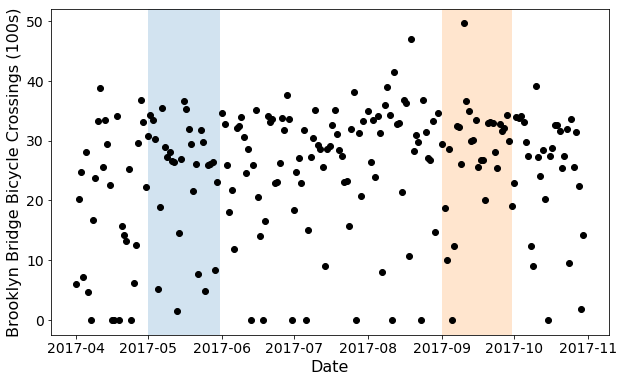

In [6]:
plt.figure(figsize=(10,6))
plt.plot(df['Brooklyn Bridge'],'ok', label='Daily Observations')

ymin, ymax = plt.ylim() # Returns the minimum and maximum y-values currently shown in the plot

# Plot shaded regions denoting the months of interest
plt.fill_between([may_start, may_end], [ymin,ymin], [ymax,ymax], alpha=0.2, label='May')
plt.fill_between([sep_start, sep_end], [ymin,ymin], [ymax,ymax], alpha=0.2, label='July')
plt.ylim(ymin,ymax)

plt.xlabel('Date', fontsize=16)
plt.ylabel('Brooklyn Bridge Bicycle Crossings (100s)', fontsize=16)
plt.xticks(fontsize=14) # Increases the size of the xtick labels
plt.yticks(fontsize=14) # Increases the size of the ytick labels
plt.show()

#### Define the prior density

In [7]:
def PriorParams():
    """
    Returns the prior (k,\theta) parameters of the Gamma density on lambda.
    
    RETURNS:
        float: The parameter k in the Gamma density 
        float: The parameter \theta in the Gamma density
        
    """
    k = 2
    theta = 20
    
    return k, theta

In [8]:
k, theta = PriorParams()

#### Plot the prior density

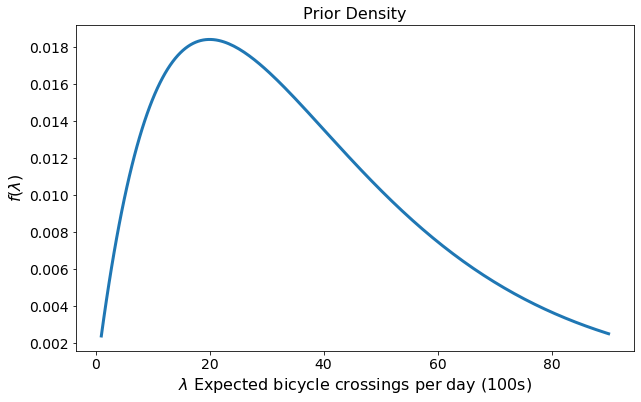

In [9]:
plt.figure(figsize=(10,6))

xs = np.linspace(1,90,200)
prior_pdf = gamma.pdf(xs, k, scale=theta)

plt.plot(xs,prior_pdf,linewidth=3)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('$\lambda$ Expected bicycle crossings per day (100s)',fontsize=16)
plt.ylabel('$f(\lambda)$',fontsize=16)
plt.title('Prior Density', fontsize=16)
plt.show()

In [10]:
def PosteriorParameters(observed_values, prior_k, prior_theta):
    """
        TODO: Update this function to calculate the posterior Gamma parameters
        
        ARGS: 
            observed_values (np.array): 1d numpy array containing observations of the daily bicycle crossings.  
                                        Each component of this vector corresponds to a daily observation.
            prior_k (float): The value of the Gamma parameter $k$ used in the prior density.
            prior_theta (float): The value of the Gamma parameter $\theta$ used in the prior density.
            
        RETURNS:
            float: The value of the Gamma parameter $k^\ast$ defining the posterior density.
            float: The value of the Gamma parameter $\theta^\ast$ defining the posterior density.
        
    """
    
    post_k = prior_k + np.sum(observed_values)
    post_theta = prior_theta/(observed_values.shape[0] * prior_theta + 1.0)
    
    
    return post_k, post_theta
    
    

#### Extract the bicycle crossings for May and Sep.

In [11]:
may_values = df.loc[ (df.index>=may_start) & (df.index<=may_end) ]['Brooklyn Bridge'].to_numpy()
sep_values = df.loc[ (df.index>=sep_start) & (df.index<=sep_end) ]['Brooklyn Bridge'].to_numpy()

#### Compute the posterior parameters using the May and September data

In [12]:
may_k, may_theta = PosteriorParameters(may_values, k,theta)
sep_k, sep_theta = PosteriorParameters(sep_values, k,theta)

#### Evaluate and plot the posterior probability densities

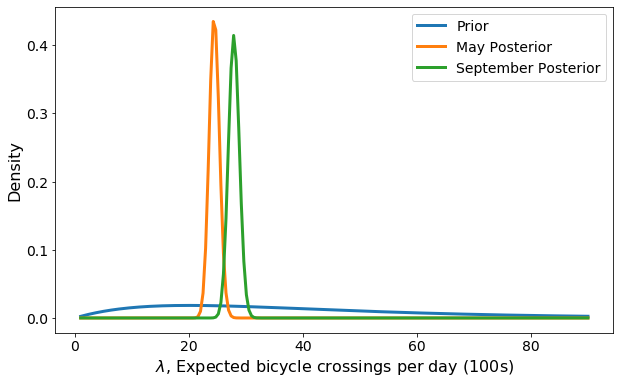

In [13]:

may_post = gamma.pdf(xs, may_k, scale=may_theta)
sep_post = gamma.pdf(xs,sep_k,scale=sep_theta)

plt.figure(figsize=(10,6))

plt.plot(xs,prior_pdf,linewidth=3,label='Prior')
plt.plot(xs,may_post,linewidth=3,label='May Posterior')
plt.plot(xs,sep_post,linewidth=3,label='September Posterior')


plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('$\lambda$, Expected bicycle crossings per day (100s)',fontsize=16)
plt.ylabel('Density',fontsize=16)
plt.show()


#### PART 4: Compute the probability that $\lambda_{May}>\lambda_{Sep}$
Hint: Use the [scipy.stats.beta](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.beta.html) class and it's CDF function.

In [14]:
prob = beta.cdf(0.5, sep_k, may_k)
print('Prob lam_{May} > lam_{Sep} = %0.4f'%prob)
print('Prob lam_{Sep} > lam_{May} = %0.4f'%(1.0-prob))


Prob lam_{May} > lam_{Sep} = 0.0046
Prob lam_{Sep} > lam_{May} = 0.9954


# Challenge Question
(this question is ungraded)

1. Read [this blog post](http://varianceexplained.org/r/empirical_bayes_baseball/) about Empirical Bayesian techniques.  You can ignore the code, just focus on the concepts.  
1. Describe how you could apply Empirical Bayesian ideas to estimate the prior density our bicycling setting.   
1. Implement a function that estimates our Gamma prior using Empirical Bayesian concepts.   (Hint: Try matching the mean and variance of a Gamma distribution to the data.)